# Modelling Polymers using Weighted Directed Graphs

The data used in this tutorial is taken from ["A graph representation of molecular ensembles for polymer property prediction" (Chem. Sci. 2022,13, 10486-10498)](https://pubs.rsc.org/en/content/articlelanding/2022/SC/D2SC02839E). The original data file can be found [here](https://github.com/coleygroup/polymer-chemprop-data/blob/main/datasets/vipea/chemprop_inputs/dataset-poly_chemprop.csv).

## Introduction

From a chemical perspective the formation and use of polymers is relatively straightforward. However, their computational representation is challenging and often fails to capture all aspects of the polymer. One way to represent polymers involves using weighted directed graphs, which include stoichiometry, polymer types and the direction and weight of the bonds. This example notebook will go through the weighted directed graph representation of polymers and how they can be used to model polymers in Chemprop.

Alternative polymer representations rely on repetitive monomer representations to depict a complete polymer chain, which is both inefficient and unrealistic. Basic graph datasets can represent a single repeating unit of one or more monomers To account for the repeating patterns of different monomers at various open bonds, weights and directions can be assigned to different connection sites. Therefore, by incorporating weights and directions into a basic graph, we can efficiently manage the repeating architecture of polymers. 

The basic unit of a polymer is the monomer. Large numbers of repeating monomers form a polymer chain. Polymers can sometimes be composed of various types of monomers in different proportions, also known as co-polymers. We will illustrate this by using an example co-polymer and create a representation using a weighted directed graph structure.

Let's take two monomers given in SMILES notation `OB(O)c1cc(F)c(B(O)O)cc1F` and `Oc1cc(O)c(Br)c(O)c1Br`.

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

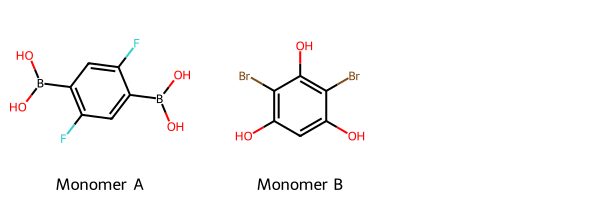

In [3]:
mA = "OB(O)c1cc(F)c(B(O)O)cc1F"
mB = "Oc1cc(O)c(Br)c(O)c1Br"
molA = Chem.MolFromSmiles(mA)
molB = Chem.MolFromSmiles(mB)

Draw.MolsToGridImage([molA, molB], legends=["Monomer A", "Monomer B"])

Both monomers exhibit functionalality attached to their benzene rings. Monomer A, contains two boronic acid groups. Monomer B, contains two bromine atoms. These two monomers can react together via. a Suzuki coupling reaction to form a polymeric species. By replacing these functionalities with open bonds we can connect the two monomers together to illustrate the resulting polymer. For the moment let's join two monomers at an open bond and represent the remaining open bonds with a virtual atom `[At]`.  

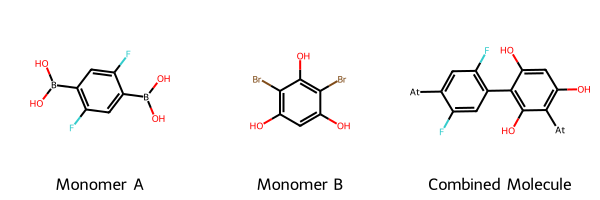

In [4]:
mAB = "[At]c1cc(F)c(c2c(O)c([At])c(O)cc2(O))cc1(F)"
molAB = Chem.MolFromSmiles(mAB)

Draw.MolsToGridImage([molA, molB, molAB], legends=["Monomer A", "Monomer B", "Combined Molecule"])

For practical implementations however, this conversion process must be developed as the virtual atom `[At]` does not fully represent the structural type of the polymer or the connection pattern with other monomers.

## Polymeric Represenation

To convert the monomers into a single structure, we need to simulate the reaction process by eliminating the functional groups and marking the open bonds with indicies.

In [5]:
def remove_duplicate_mols(mols):
    smiles = list(set([Chem.MolToSmiles(m, canonical=True) for m in mols]))
    return [Chem.MolFromSmiles(s) for s in smiles]

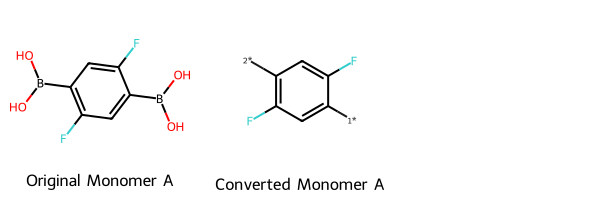

In [6]:
molA_s = molA
for i in [1, 2]:
    smarts = f"[*:1]([B](-O)(-O))>>[*:1]-[*{i}]" # SMARTS to emulate the reaction of the boronic acid to an open bond
    reaction = AllChem.ReactionFromSmarts(smarts)
    products = reaction.RunReactants((molA_s,))
    products = remove_duplicate_mols([r[0] for r in products])
    molA_s = products[0]
    
Draw.MolsToGridImage([molA, molA_s], legends=["Original Monomer A", "Converted Monomer A"])

The boronic acid groups have now been replaced with an open bond and a corresponding index number. We can now repeat the process for monomer B.

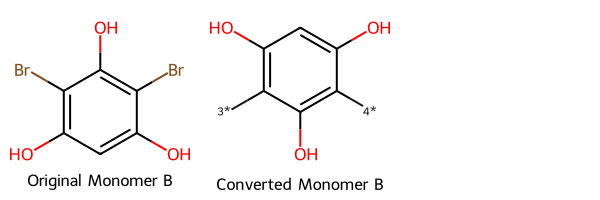

In [7]:
molB_s = molB
for i in [3, 4]:
    smarts = f"[*:1]Br>>[*:1]-[*{i}]" # SMARTS to emulate the reaction of the bromine to an open bond
    reaction = AllChem.ReactionFromSmarts(smarts)
    products = reaction.RunReactants((molB_s,))
    products = remove_duplicate_mols([r[0] for r in products])
    molB_s = products[0]
    
Draw.MolsToGridImage([molB, molB_s], legends=["Original Monomer B", "Converted Monomer B"])

To represent both monomers while keeping a valid SMILES, we can join both SMILES strings with a `.`.

Combined AB SMILES: [1*]c1cc(F)c([2*])cc1F.[3*]c1c(O)cc(O)c([4*])c1O


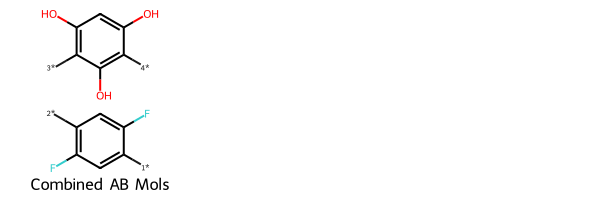

In [8]:
molA_smiles = Chem.MolToSmiles(molA_s, canonical=True)
molB_smiles = Chem.MolToSmiles(molB_s, canonical=True)
combined_AB_smiles = f"{molA_smiles}.{molB_smiles}"
combined_AB_mols = Chem.MolFromSmiles(combined_AB_smiles)
print(f"Combined AB SMILES: {combined_AB_smiles}")
Draw.MolsToGridImage([combined_AB_mols], legends=["Combined AB Mols"])

### Weight and Direction Assignments

In the previous step, we created a monomer wireframe capable of referencing different indexed open bonds to form various types of polymer chains. However, the goal is to condense the complete polymer chain architecture into a smaller yet robust representation using weights and directions. Weights can be assigned at two levels: to the individual monomer atoms and to each bond. While the direction is generally consistent across different monomers, there in an edge case where a bond refers to itself (also known as a self-loop or self-edge in graphs), where an open bond connects with the same open bond of another monomer with an identical structure. For example a bond between atom 1* of Monomer A and atom 2* of another Monomer A in the image above.

#### Weight assignments to monomer elements

Polymers can be composed of monomers contributing in varying proportions. The proportion that each monomer contributes is fairly straightforward. For example, if monomer A and monomer B contribute to the polymer in a 3:1 ratio, the weights assigned to monomer A and monomer B are 0.75 and 0.25 respectively. In this way, the contribution of each monomer fragment to the total polymer is represented by the weights of the nodes in the graph.

The stoichiometry of the polymer can impose limitations on the weights assigned to the monomers. For example, alternating polymers with the structure `ABABABAB...` must have an almost equal fraction of monomer A and monomer B. Whereas, in block and random co-polymers, the fractions can vary and have different float values.

For representational purposes we denote the weights of the monomers with a separator "|". For example for alternating polymers the monomer weights would be represented as `|0.5|0.5|`.

#### Weight assignments to bonds

Since we cannot replicate the complete repitition of the monomer, we must convert the stoichiometric constraints into edge weights in the node representation.

When determining a weight for the represenationation, we must divide the total contribution by the effective contribution. The total contribution value can be confusing since not all monomers are included in the chain. Therefore, we will use the same fragment ratio used for assigning weights to the monomer elements. For example, if the monomers are in a 3:1 ratio, we will consider monomer arrangments in multiples of 4. For block co-polymers, we would use "AAAABBBB".

##### 1. Weights for alternating polymers

For alternating polymers, the structure will resemble "ABABABAB". Therefore, monomers A and B will never connect to themselves, so the case of self-edges does not apply here. Considering the probability occurence, the bonds between A-B and B-A will each be assigned a weight of `0.5`.

Combined AB SMILES: [1*]c1cc(F)c([2*])cc1F.[3*]c1c(O)cc(O)c([4*])c1O


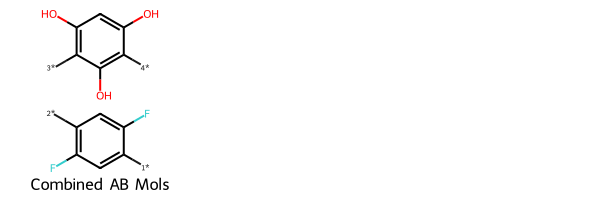

In [9]:
print(f"Combined AB SMILES: {combined_AB_smiles}")
Draw.MolsToGridImage([combined_AB_mols], legends=["Combined AB Mols"])

We represent the combination of atom indexes and bond weights for both the forward and reverse bond formation as a single polymer rule, separated by `:`. For example, if the weights of the bond formation from A to B is 0.25 and B to A is 0.75, it is represented as `1-2:0.25:0.75`. Multiple polymer rules are indicated starting with a `<` and separating each rule similarly. For instance, `<1-2:0.5:0.5<3-4:0.25:0.75` signifies connection between index 1 open bond and index 2 open bond with a weight of 0.5, and between index 3 open bond and index 4 open bond with weights 0.25 and 0.75 for the forward and reverse bond formation respectively. 

In our example case, there are 4 indexes open bonds, and self-edges are not present (i.e. 1-2 or 3-4 bonds cannot be formed). Therefore, the only possible bonds formed are 1-3, 1-4, 2-3 and 2-4. Each bond will have a weight of 0.5.

The polymer represenation of this is: `<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5`

In [10]:
# For an alternating co-polymer
alt_edge_content = [(1, 3, 0.5, 0.5),
                    (1, 4, 0.5, 0.5),
                    (2, 3, 0.5, 0.5),
                    (2, 4, 0.5, 0.5)]
alt_edge_string = "".join([f"<{e[0]}-{e[1]}:{e[2]}:{e[3]}" for e in alt_edge_content])
print(f"Polymer Rule String for alternate co-polymer: {alt_edge_string}")

Polymer Rule String for alternate co-polymer: <1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5


##### 2. Weights for block co-polymers

Block copolymers are characterized by the structure 'AAAABBBB'. Where, monomer A occupies one region and monomer B occupies another.

To model the weight distribution of an 'AAAABBBB' block copolymer, we represent it using eight monomer units. A total of eight bonds can be formed within this sequence. Six of these bonds are homogeneous (A-A or B-B), resulting in a bond probability and weight of 6/8. Conversely, only one heterogeneous bond (A-B) is possible, yielding a probability and weight of 1/8. The bond weight distribution based on atom indices is as follows:

- 1-2: 6/8
- 3-4: 6/8
- 1-3: 1/8
- 1-4: 1/8
- 2-3: 1/8
- 2-4: 1/8

This information can be converted into a polymer rule:

In [11]:
# For a block co-polymer with no self edges
block_edge_content_wo_self_edges = [(1, 2, 6/8, 6/8),  # within A
                                    (3, 4, 6/8, 6/8),  # within B
                                    (1, 3, 1/8, 1/8),  # between A and B
                                    (1, 4, 1/8, 1/8),
                                    (2, 3, 1/8, 1/8),
                                    (2, 4, 1/8, 1/8)]
block_no_self_edges_string = "".join([f"<{e[0]}-{e[1]}:{e[2]}:{e[3]}" for e in block_edge_content_wo_self_edges])
print(f"Polymer Rule String for Block without Self Edges: {block_no_self_edges_string}")

Polymer Rule String for Block without Self Edges: <1-2:0.75:0.75<3-4:0.75:0.75<1-3:0.125:0.125<1-4:0.125:0.125<2-3:0.125:0.125<2-4:0.125:0.125


If we consider self-edges (i.e. the same monomer structure connects to itself at same open bond) the probabilty weight between homogeneous bonds will be altered. For example, the connection for A-A at index 1 can be at two open bonds i.e. 1-2 or 1-1 (self-edge) hence the previous probability will be halved resulting in 3/8. Rest of the heterogenous bond weights will remain the same. So resulting weights will be as follows.

- 1-2: 3/8
- 1-1: 3/8
- 2-2: 3/8
- 3-4: 3/8
- 3-3: 3/8
- 4-4: 3/8
- 1-3: 1/8
- 1-4: 1/8
- 2-3: 1/8
- 2-4: 1/8

This information can be converted into a polymer rule:

In [12]:
# For a block co-polymer with self edges
block_edge_content = [(1, 2, 3/8, 3/8),  # within A
                      (1, 1, 3/8, 3/8),
                      (2, 2, 3/8, 3/8),
                      (3, 4, 3/8, 3/8),  # within B
                      (3, 3, 3/8, 3/8),
                      (4, 4, 1/8, 1/8),
                      (1, 3, 1/8, 1/8),  # between A and B
                      (1, 4, 1/8, 1/8),
                      (2, 3, 1/8, 1/8),
                      (2, 4, 1/8, 1/8)]
block_edges_string = "".join([f"<{e[0]}-{e[1]}:{e[2]}:{e[3]}" for e in block_edge_content])
print(f"Polymer Rule String for Block with Self Edges: {block_edges_string}")

Polymer Rule String for Block with Self Edges: <1-2:0.375:0.375<1-1:0.375:0.375<2-2:0.375:0.375<3-4:0.375:0.375<3-3:0.375:0.375<4-4:0.125:0.125<1-3:0.125:0.125<1-4:0.125:0.125<2-3:0.125:0.125<2-4:0.125:0.125


##### 3. Weights for Random Polymers

The weight calculation for a random polymer chain is straightforward. Without self-edges, any indexed bond can connect to another open bond of the same monomer (e.g., 1-2 or 2-1) with a probability of 1/2. Similarly, any indexed bond connecting with an indexed open bond of another monomer type (e.g., 1-3, 1-4, 2-3, 2-4) has a probability of 1/3. When considering self-edges, every indexed bond can connect with every other indexed bond (i.e., at 4 possible bonding sites), resulting in a probability weight of 1/4. Thus, with or without self-edges, we can determine the following weight distribution.

With self-edge:
- 1-1 -> 0.25
- 1-2 -> 0.25
... (same for all bond connection)

Without self-edge:
- 1-2 -> 0.5
- 3-4 -> 0.5
- 1-3 -> 0.33
- 1-4 -> 0.33
- 2-3 -> 0.33
- 2-4 -> 0.33

In [13]:
# For a random co-polymer with self edges
possible_bond_site_indexes = [1, 2, 3, 4]
random_edge_content = []
for i in possible_bond_site_indexes:
        for j in possible_bond_site_indexes:
                random_edge_content.append([i, j, 0.25, 0.25])
random_edges_string = "".join([f"<{e[0]}-{e[1]}:{e[2]}:{e[3]}" for e in random_edge_content])
print(f"Polymer Rule String for Block with Self Edges: {random_edges_string}")

Polymer Rule String for Block with Self Edges: <1-1:0.25:0.25<1-2:0.25:0.25<1-3:0.25:0.25<1-4:0.25:0.25<2-1:0.25:0.25<2-2:0.25:0.25<2-3:0.25:0.25<2-4:0.25:0.25<3-1:0.25:0.25<3-2:0.25:0.25<3-3:0.25:0.25<3-4:0.25:0.25<4-1:0.25:0.25<4-2:0.25:0.25<4-3:0.25:0.25<4-4:0.25:0.25


In [14]:
# For a random co-polymer without self edges
random_edge_content_wo_self_edge = [(1, 2, 1/2, 1/2),  # within A
                                    (3, 4, 1/2, 1/2),  # within B
                                    (1, 3, 1/3, 1/3),  # between A and B
                                    (1, 4, 1/3, 1/3),
                                    (2, 3, 1/3, 1/3),
                                    (2, 4, 1/3, 1/3)]
random_edges_wo_self_edge_string = "".join([f"<{e[0]}-{e[1]}:{e[2]:.2f}:{e[3]:.2f}" for e in random_edge_content_wo_self_edge])
print(f"Polymer Rule String for Random without Self Edges: {random_edges_wo_self_edge_string}")

Polymer Rule String for Random without Self Edges: <1-2:0.50:0.50<3-4:0.50:0.50<1-3:0.33:0.33<1-4:0.33:0.33<2-3:0.33:0.33<2-4:0.33:0.33


In this manner, we can add weights of the monomer fragments and bonds to the graph data.

### Final Polymer Representation

In the previous steps, we created a wireframe for monomers with indexed open bonds and calculated the weights for bonds and elements based on stoichiometry and the monomer fragment distribution. Now, we need to combine these into a single string format to construct a weighted directed graph. We have the information in three parts:
 
1. The indexed monomer wireframe
2. Assigned weights to elements
3. Polymer rules containing polymer weights mapped with direction

We concatenate these three parts into a single string. In our case, we have a monomer indexed representation of two monomers given as `[1*]c1cc(F)c([2*])cc1F.[3*]c1c(O)cc(O)c([4*])c1O`. For the second part, the fractions of the two monomers were asssigned to be 0.5 for each, `|0.5|0.5|`.

Finally, in the polymer rules section, there could be three variations of the same monomer corresponding to different stoichiometries. For each monomer example considered, there can be at least three types (i.e., Alternating, Block, and Random). Each type will have a different polymer rules string concatenated, resulting in different string representations from the same monomer string.

*Note - There could be different cases, if there are self-edges possible in the monomer stoichiomentry.*

In [15]:
# For our example 
monomer_fragment_string = "|0.5|0.5|"
poly_wireframe_w_weights = combined_AB_smiles + monomer_fragment_string
print(f"Repeatable weighted base representation: {poly_wireframe_w_weights}")

Repeatable weighted base representation: [1*]c1cc(F)c([2*])cc1F.[3*]c1c(O)cc(O)c([4*])c1O|0.5|0.5|


Once we have the base string representation, we will append the polymer rule strings to the end of the base string. Since the polymer rules for this polymer have already been determined in previous code blocks, we will use those strings to construct the final string.

#### i. Without self-edges

In [16]:
polymer_alternate = poly_wireframe_w_weights + alt_edge_string
polymer_block = poly_wireframe_w_weights + block_no_self_edges_string
polymer_random = poly_wireframe_w_weights + random_edges_wo_self_edge_string
print(f"The string representation of alternating polymer: {polymer_alternate}")
print(f"The string representation of block polymer: {polymer_block}")
print(f"The string representation of random polymer: {polymer_random}")

The string representation of alternating polymer: [1*]c1cc(F)c([2*])cc1F.[3*]c1c(O)cc(O)c([4*])c1O|0.5|0.5|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5
The string representation of block polymer: [1*]c1cc(F)c([2*])cc1F.[3*]c1c(O)cc(O)c([4*])c1O|0.5|0.5|<1-2:0.75:0.75<3-4:0.75:0.75<1-3:0.125:0.125<1-4:0.125:0.125<2-3:0.125:0.125<2-4:0.125:0.125
The string representation of random polymer: [1*]c1cc(F)c([2*])cc1F.[3*]c1c(O)cc(O)c([4*])c1O|0.5|0.5|<1-2:0.50:0.50<3-4:0.50:0.50<1-3:0.33:0.33<1-4:0.33:0.33<2-3:0.33:0.33<2-4:0.33:0.33


#### ii. With self-edges

In case of self-edges, an alternating polymer is not possible. We can include the remaining cases of random and block polymer to form a string representation as follows.

In [17]:
polymer_block_w_self_edge = poly_wireframe_w_weights + block_edges_string
polymer_random_w_self_edge = poly_wireframe_w_weights + random_edges_string 
print(f"The string representation of block polymer with self-edge: {polymer_block_w_self_edge}")
print(f"The string representation of random polymer wth self-edge: {polymer_random_w_self_edge}")

The string representation of block polymer with self-edge: [1*]c1cc(F)c([2*])cc1F.[3*]c1c(O)cc(O)c([4*])c1O|0.5|0.5|<1-2:0.375:0.375<1-1:0.375:0.375<2-2:0.375:0.375<3-4:0.375:0.375<3-3:0.375:0.375<4-4:0.125:0.125<1-3:0.125:0.125<1-4:0.125:0.125<2-3:0.125:0.125<2-4:0.125:0.125
The string representation of random polymer wth self-edge: [1*]c1cc(F)c([2*])cc1F.[3*]c1c(O)cc(O)c([4*])c1O|0.5|0.5|<1-1:0.25:0.25<1-2:0.25:0.25<1-3:0.25:0.25<1-4:0.25:0.25<2-1:0.25:0.25<2-2:0.25:0.25<2-3:0.25:0.25<2-4:0.25:0.25<3-1:0.25:0.25<3-2:0.25:0.25<3-3:0.25:0.25<3-4:0.25:0.25<4-1:0.25:0.25<4-2:0.25:0.25<4-3:0.25:0.25<4-4:0.25:0.25


These data string representations are not widely adopted, as the use of weighted directed graphs in these fields is relatively recent and specifically compatible with Weighted Directed Message Passing Neural Networks (wD-MPNN). However, this string representation effectively stores all the necessary data to form a valid weighted directed graph structure from polymer data.

## Using Weighted Polymer Representations with ChemProp

Now that we have a representation of our polymer including the monomer and bond weightings we can use them to train a ChemProp model to predict the electron affinity of a set of polymers.

In [18]:
import pandas as pd
from pathlib import Path

from lightning import pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

from chemprop import data, featurizers, models, nn

### Load in the dataset

We will use a reduced version of the dataset with only 100 datapoints to reduce training time. The full dataset can be found at the top of the notebook and will yield much better metrics.

In [19]:
chemprop_dir = Path.cwd().parent
input_path = f"/home/shortm/Documents/ML/dataset-poly_chemprop.csv"

In [20]:
num_workers = 0
smiles_column = "poly_chemprop_input"
target_columns = ["EA vs SHE (eV)"]

In [21]:
df_input = pd.read_csv(input_path)
df_input

,poly_chemprop_input,EA vs SHE (eV),IP vs SHE (eV)
0,[*:1]c1cc(F)c([*:2])cc1F.[*:3]c1c(O)cc(O)c([*:...,-3.406210,1.808017
1,[*:1]c1cc(F)c([*:2])cc1F.[*:3]c1c(O)cc(O)c([*:...,-2.991909,1.761062
2,[*:1]c1cc(F)c([*:2])cc1F.[*:3]c1c(O)cc(O)c([*:...,-3.196570,1.817267
3,[*:1]c1cc(F)c([*:2])cc1F.[*:3]c1cc(F)c([*:4])c...,-2.472685,2.635116
4,[*:1]c1cc(F)c([*:2])cc1F.[*:3]c1cc(F)c([*:4])c...,-2.469582,2.608899
...,...,...,...
42961,[*:1]c1ccc2c(c1)S(=O)(=O)c1cc([*:2])ccc1-2.[*:...,-1.366831,2.531914
42962,[*:1]c1ccc2c(c1)S(=O)(=O)c1cc([*:2])ccc1-2.[*:...,-2.784383,1.455677
42963,[*:1]c1ccc2c(c1)S(=O)(=O)c1cc([*:2])ccc1-2.[*:...,-2.861863,1.523136
42964,[*:1]c1ccc2c(c1)S(=O)(=O)c1cc([*:2])ccc1-2.[*:...,-2.891160,0.940259


### Get Polymer representations and targets

In [22]:
smis = df_input.loc[:, smiles_column].values
ys = df_input.loc[:, target_columns].values

In [23]:
smis[:5] # Show the first 5 polymer string representations

array(['[*:1]c1cc(F)c([*:2])cc1F.[*:3]c1c(O)cc(O)c([*:4])c1O|0.5|0.5|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5',
       '[*:1]c1cc(F)c([*:2])cc1F.[*:3]c1c(O)cc(O)c([*:4])c1O|0.5|0.5|<1-2:0.375:0.375<1-1:0.375:0.375<2-2:0.375:0.375<3-4:0.375:0.375<3-3:0.375:0.375<4-4:0.125:0.125<1-3:0.125:0.125<1-4:0.125:0.125<2-3:0.125:0.125<2-4:0.125:0.125',
       '[*:1]c1cc(F)c([*:2])cc1F.[*:3]c1c(O)cc(O)c([*:4])c1O|0.5|0.5|<1-3:0.25:0.25<1-4:0.25:0.25<2-3:0.25:0.25<2-4:0.25:0.25<1-2:0.25:0.25<3-4:0.25:0.25<1-1:0.25:0.25<2-2:0.25:0.25<3-3:0.25:0.25<4-4:0.25:0.25',
       '[*:1]c1cc(F)c([*:2])cc1F.[*:3]c1cc(F)c([*:4])cc1C#N|0.5|0.5|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5',
       '[*:1]c1cc(F)c([*:2])cc1F.[*:3]c1cc(F)c([*:4])cc1C#N|0.5|0.5|<1-2:0.375:0.375<1-1:0.375:0.375<2-2:0.375:0.375<3-4:0.375:0.375<3-3:0.375:0.375<4-4:0.125:0.125<1-3:0.125:0.125<1-4:0.125:0.125<2-3:0.125:0.125<2-4:0.125:0.125'],
      dtype=object)

In [24]:
ys[:5] # Show the first 5 targets

array([[-3.40621031],
       [-2.99190912],
       [-3.19657011],
       [-2.47268484],
       [-2.46958186]])

### Get polymer datapoints

In [25]:
all_data = [data.PolymerDatapoint.from_smi(smi, y=y) for smi, y in zip(smis, ys)]

### Perform data splitting for training, validation and testing

In [26]:
# Available split types
list(data.SplitType.keys())

['SCAFFOLD_BALANCED',
 'RANDOM_WITH_REPEATED_SMILES',
 'RANDOM',
 'KENNARD_STONE',
 'KMEANS']

Split the data into a training, validation and test set.

In [27]:
mols = [d.mol for d in all_data]
train_indicies, val_indicies, test_indicies = data.make_split_indices(mols, "random", (0.8, 0.1, 0.1))
train_data, val_data, test_data = data.split_data_by_indices(
    all_data,
    train_indicies, val_indicies, test_indicies
)

The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)


### Get PolymerDataset

Create a dataset for the training, validation and test data using the `PolymerMolGraphFeaturizer()` and normalize the targets.

In [28]:
featurizer = featurizers.PolymerMolGraphFeaturizer()

train_dataset = data.PolymerDataset(train_data[0], featurizer)
scaler = train_dataset.normalize_targets()

val_dataset = data.PolymerDataset(val_data[0], featurizer)
val_dataset.normalize_targets(scaler)

test_dataset = data.PolymerDataset(test_data[0], featurizer)

### Get DataLoader

Build dataloaders for the training, validation and test sets.

In [29]:
train_loader = data.build_dataloader(train_dataset, num_workers=num_workers)
val_loader = data.build_dataloader(val_dataset, num_workers=num_workers, shuffle=False)
test_loader = data.build_dataloader(test_dataset, num_workers=num_workers, shuffle=False)

## Change the Weighted Directed Message-Passing Neural Network (wD-MPNN) inputs here

The default MPNN will use weighting by default. For small molecule tasks all weights are set to 1 (i.e. no weighting for atoms or bonds). Weighting is only invoked if used with a polymer dataset, or if the weight matricies are provided manually by the user.

#### Message Passing

A `Message Passing` constructs molecule graphs using message passing to learn node-level representations.

Options are `mp = nn.BondMessagePassing()` or `mp = nn.AtomMessagePassing()`.

In [30]:
mp = nn.BondMessagePassing()

#### Aggregation

An `Aggregation` is responsible for constructing a graph-level representation from the set of node-level representations after message passing.

Available options can be found in `nn.agg.AggregationRegistry`, including:
- `agg = nn.MeanAggregation()`
- `agg = nn.SumAggregation()`
- `agg = nn.NormAggregation()`

In [31]:
print(nn.agg.AggregationRegistry)

ClassRegistry {
    'mean': <class 'chemprop.nn.agg.MeanAggregation'>,
    'sum': <class 'chemprop.nn.agg.SumAggregation'>,
    'norm': <class 'chemprop.nn.agg.NormAggregation'>
}


In [32]:
agg = nn.MeanAggregation()

### Feed-Forward Network (FNN)

A `FFN` takes the aggregated representation and makes target predictions.

Available options can be found in `nn.PredictorRegistry`.

In [33]:
print(nn.PredictorRegistry)

ClassRegistry {
    'regression': <class 'chemprop.nn.predictors.RegressionFFN'>,
    'regression-mve': <class 'chemprop.nn.predictors.MveFFN'>,
    'regression-evidential': <class 'chemprop.nn.predictors.EvidentialFFN'>,
    'regression-quantile': <class 'chemprop.nn.predictors.QuantileFFN'>,
    'classification': <class 'chemprop.nn.predictors.BinaryClassificationFFN'>,
    'classification-dirichlet': <class 'chemprop.nn.predictors.BinaryDirichletFFN'>,
    'multiclass': <class 'chemprop.nn.predictors.MulticlassClassificationFFN'>,
    'multiclass-dirichlet': <class 'chemprop.nn.predictors.MulticlassDirichletFFN'>,
    'spectral': <class 'chemprop.nn.predictors.SpectralFFN'>
}


Create function to unscale the targets

In [34]:
output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)

As we are performing a regression task, we will choose the `nn.RegressionFFN` FFN.

In [35]:
ffn = nn.RegressionFFN(output_transform=output_transform)

### Batch Norm

A `BatchNorm` normalizes the outputs of the aggreation by re-centering and re-scaling.

In [36]:
# Whether to use batch normalisation
batch_norm = True

### Metrics

`Metrics` are the ways to evaluate the performance of the model predictions.

Available options can be found in `metrics.MetricRegistry`.

In [37]:
print(nn.metrics.MetricRegistry)

ClassRegistry {
    'mse': <class 'chemprop.nn.metrics.MSE'>,
    'mae': <class 'chemprop.nn.metrics.MAE'>,
    'rmse': <class 'chemprop.nn.metrics.RMSE'>,
    'bounded-mse': <class 'chemprop.nn.metrics.BoundedMSE'>,
    'bounded-mae': <class 'chemprop.nn.metrics.BoundedMAE'>,
    'bounded-rmse': <class 'chemprop.nn.metrics.BoundedRMSE'>,
    'r2': <class 'chemprop.nn.metrics.R2Score'>,
    'binary-mcc': <class 'chemprop.nn.metrics.BinaryMCCMetric'>,
    'multiclass-mcc': <class 'chemprop.nn.metrics.MulticlassMCCMetric'>,
    'roc': <class 'chemprop.nn.metrics.BinaryAUROC'>,
    'prc': <class 'chemprop.nn.metrics.BinaryAUPRC'>,
    'accuracy': <class 'chemprop.nn.metrics.BinaryAccuracy'>,
    'f1': <class 'chemprop.nn.metrics.BinaryF1Score'>
}


As we are performing a regression task we will select RMSE and MAE

In [38]:
metric_list = [nn.metrics.RMSE(), nn.metrics.MAE()] # Only the first metric is used for training and early stopping

### Construct the wD-MPNN

In [39]:
wdmpnn = models.MPNN(mp, agg, ffn, batch_norm, metric_list)
wdmpnn

MPNN(
  (message_passing): BondMessagePassing(
    (W_i): Linear(in_features=86, out_features=300, bias=False)
    (W_h): Linear(in_features=300, out_features=300, bias=False)
    (W_o): Linear(in_features=372, out_features=300, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (tau): ReLU()
    (V_d_transform): Identity()
    (graph_transform): Identity()
  )
  (agg): MeanAggregation()
  (bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=300, out_features=300, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.0, inplace=False)
        (2): Linear(in_features=300, out_features=1, bias=True)
      )
    )
    (criterion): MSE(task_weights=[[1.0]])
    (output_transform): UnscaleTransform()
  )
  (X_d_transform): Identity()
  (metrics): ModuleList(
    (0): RMSE(task_weights=[[1.0]])
    (1): MAE(task_weigh

## Set up the trainer

In [42]:
# Configure model checkpointing
checkpointing = ModelCheckpoint(
    "checkpoints", # Directory where model checkpoints will be saved
    "best-{epoch}-{val_loss:.2f}", # Filename format for the checkpoints
    "val_loss", # Metric used to select the best checkpoint (based on validation loss)
    mode="min", # Save the checkpoint with the lowest validation loss (minimization objective)
    save_last=True, # Always save the most recent checkpoint, even if its not the best
)

# Configure model early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', # Metric used to monitor early stopping
    mode='min',
    patience=15, # Number of epochs to wait for a lower metric value before early stopping
)

trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=True,
    enable_progress_bar=True,
    accelerator="auto",
    devices="auto",
    max_epochs=100, # Number of epochs to train for
    callbacks=[checkpointing, early_stopping],
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Start training

In [43]:
trainer.fit(wdmpnn, train_loader, val_loader)

Loading `train_dataloader` to estimate number of stepping batches.

  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | message_passing | BondMessagePassing | 227 K  | train
1 | agg             | MeanAggregation    | 0      | train
2 | bn              | BatchNorm1d        | 600    | train
3 | predictor       | RegressionFFN      | 90.6 K | train
4 | X_d_transform   | Identity           | 0      | train
5 | metrics         | ModuleList         | 0      | train
---------------------------------------------------------------
318 K     Trainable params
0         Non-trainable params
318 K     Total params
1.276     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


Epoch 69: 100%|██████████| 538/538 [09:03<00:00,  0.99it/s, train_loss_step=0.100, val_loss=0.0127, train_loss_epoch=0.00378]   


## Test Results

In [44]:
results = trainer.test(dataloaders=test_loader, ckpt_path="best")

Restoring states from the checkpoint path at /home/shortm/Documents/Code/chemprop_polymer/examples/checkpoints/best-epoch=54-val_loss=0.01.ckpt
Loaded model weights from the checkpoint at /home/shortm/Documents/Code/chemprop_polymer/examples/checkpoints/best-epoch=54-val_loss=0.01.ckpt
/home/shortm/Documents/Code/chemprop_polymer/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │   0.026480387896299362    │
│         test/rmse         │    0.04522588104009628    │
└───────────────────────────┴───────────────────────────┘